# Installing and importing required libraries

In [ ]:
# Installing necessary packages
!pip install tf-keras-vis tensorflow
!pip install visualkeras
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install Pillow
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import shutil
import os

import glob

from PIL import Image
from PIL import ImageFilter

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import load_img
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Main directory path


In [ ]:
main_dir='/content/drive/MyDrive/GLENDA'

In [ ]:
os.chdir(main_dir)

In [ ]:
!cd "$main_dir"

In [ ]:
!unzip GLENDA

In [ ]:
!unzip Glenda_v1.5_classes.zip


## Copying files to main data folder

In [ ]:
!mkdir "$main_dir"/data/

In [ ]:
!mkdir "$main_dir"/data/no_pathology


In [ ]:
!rm -rf "$main_dir"/data/pathology


In [ ]:
shutil.copytree(main_dir+'/Glenda_v1.5_classes/frames/', main_dir+'/data/pathology/')

'/content/drive/MyDrive/GLENDA/data/pathology/'

In [ ]:
!rm -rf "$main_dir"/data/no_pathology

#### Copying original no_pathology dataset to main data folder

In [ ]:
frame_list=os.listdir(main_dir+'/no_pathology/frames')

In [ ]:

src_dir=main_dir+'/no_pathology/frames'
dest_dir=main_dir+'/data/no_pathology'
count=0
for frame in frame_list:

  final_src_dir=os.path.join(src_dir,frame)
  img_list=os.listdir(final_src_dir)
  for img in img_list:
    # print(os.path.splitext(img)[0])
    final_img_src_dir=os.path.join(final_src_dir,img)
    final_img_dest_dir=os.path.join(dest_dir, img)
    
    if os.path.exists(final_img_dest_dir):
      final_img_dest_dir=os.path.splitext(final_img_dest_dir)[0]+str(count)+".jpg"
      

    shutil.move(final_img_src_dir, final_img_dest_dir)

  count+=1


# ***DATA PREPROCESSING***

## Oversampling pythological dataset

In [ ]:
filelist = glob.glob(main_dir+'/data/pathology/*.jpg')
for count in range(0,3):
  # imagefile
  os.chdir(main_dir+"/data/pathology")
  for imagefile in filelist:
    im=Image.open(imagefile)
    im=im.convert("RGB")
    im_enhance = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
    im_unsharp = im.filter(ImageFilter.UnsharpMask)
    im_median = im.filter(ImageFilter.MedianFilter)
    im_blur = im.filter(ImageFilter.BLUR)
    im_min = im.filter(ImageFilter.MinFilter)
    im_max = im.filter(ImageFilter.MaxFilter)
    im_mode = im.filter(ImageFilter.ModeFilter)
    im_sharp = im.filter(ImageFilter.SHARPEN)
    im_smooth = im.filter(ImageFilter.SMOOTH)
    base_name=os.path.basename(os.path.splitext(imagefile)[0])
    im_enhance.save(base_name+str(count)+'_enh.jpg')
    im_unsharp.save(base_name+str(count)+'_us.jpg')
    im_median.save(base_name+str(count)+'_me.jpg')
    im_blur.save(base_name+str(count)+'_blur.jpg')
    im_min.save(base_name+str(count)+'_min.jpg')
    im_max.save(base_name+str(count)+'_max.jpg')
    im_mode.save(base_name+str(count)+'_mode.jpg')
    im_sharp.save(base_name+str(count)+'_sharp.jpg')
    im_smooth.save(base_name+str(count)+'_smooth.jpg')



### Looking at the data

In [ ]:
data=tf.keras.utils.image_dataset_from_directory(main_dir+"/data/")


Found 23214 files belonging to 2 classes.


In [ ]:
steps= data.as_numpy_iterator()

In [ ]:
batch=steps.next()

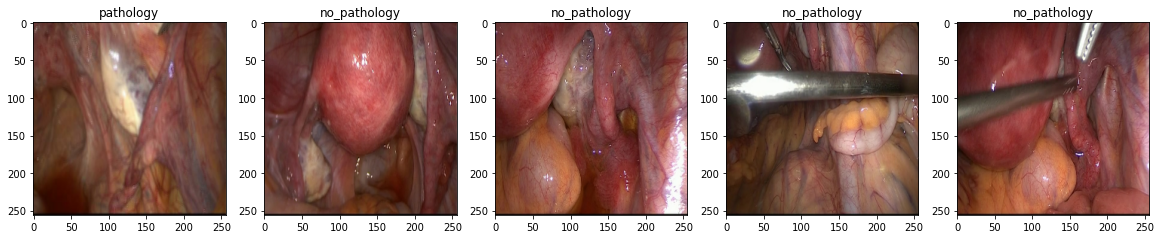

In [ ]:
fig, ax=plt.subplots(ncols=5, figsize=(20,20))
classes=['no_pathology','pathology']
for idx, img in enumerate(batch[0][:5]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(classes[batch[1][idx]])



> Note:  

*    0- no_pathology
*    1-pathology


## **Scaling the dataset**

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iter= data.as_numpy_iterator()


In [ ]:
batch=scaled_iter.next()

In [ ]:
batch[0].max()

1.0

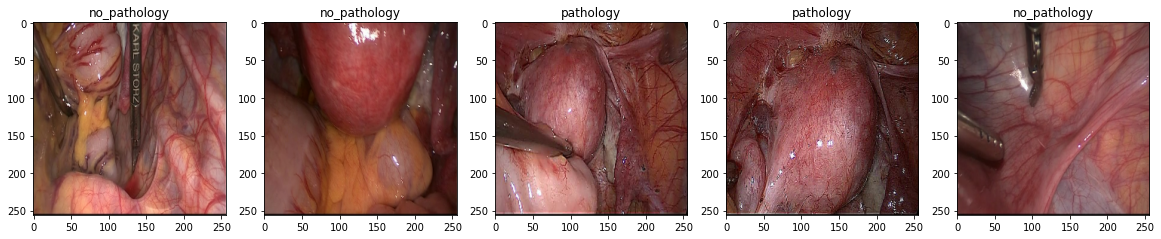

In [ ]:
fig, ax=plt.subplots(ncols=5, figsize=(20,20))
classes=['no_pathology','pathology']
for idx, img in enumerate(batch[0][:5]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(classes[batch[1][idx]])

## **Splitting the dataset**

In [ ]:
len(data)

726

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [ ]:
#using take and skip method from image_dataset_from_directory for splitting the dataset

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size).skip(val_size).take(test_size)

In [ ]:
len(train), len(val), len(test)

(508, 145, 73)

# ***DEEP LEARNING***

## Sequential Custom

In [ ]:
# Creating the custom model
sequential_model= Sequential()

# Adding the layers
sequential_model.add(Conv2D(32, kernel_size=(3,3), activation="relu", padding="valid", input_shape=(256,256,3)))
sequential_model.add(Conv2D(32, kernel_size=(3,3), activation="relu", padding="valid"))
sequential_model.add(MaxPool2D(pool_size=(2,2)))

sequential_model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="valid"))
sequential_model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="valid"))
sequential_model.add(MaxPool2D(pool_size=(2,2)))

sequential_model.add(Conv2D(128, kernel_size=(3,3), activation="relu", padding="valid"))
sequential_model.add(MaxPool2D(pool_size=(2,2)))

sequential_model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding="valid"))
sequential_model.add(MaxPool2D(pool_size=(2,2)))

sequential_model.add(Conv2D(512, kernel_size=(3,3), activation="relu", padding="valid"))
sequential_model.add(MaxPool2D(pool_size=(2,2)))

sequential_model.add(Flatten())
sequential_model.add(Dense(64, activation='relu'))

# Output layer
sequential_model.add(Dense(1, activation='sigmoid'))

# Viewing the summary of the model
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                    

In [ ]:
# Compiling the model
sequential_model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer='adam', metrics=["accuracy"])

## Training

In [ ]:
#for logging of our model
logsdir="logs"

In [ ]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logsdir)
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

In [ ]:
hist=sequential_model.fit(train, validation_data=val, callbacks=[tensorboard_callback, early_stop], epochs=20, workers=8)

Epoch 1/20
508/508 [==============================] - 1961s 4s/step - loss: 0.6894 - accuracy: 0.5487 - val_loss: 0.6878 - val_accuracy: 0.5444
Epoch 2/20
508/508 [==============================] - 142s 277ms/step - loss: 0.4284 - accuracy: 0.7818 - val_loss: 0.1591 - val_accuracy: 0.9461
Epoch 3/20
508/508 [==============================] - 142s 278ms/step - loss: 0.0999 - accuracy: 0.9632 - val_loss: 0.0696 - val_accuracy: 0.9812
Epoch 4/20
508/508 [==============================] - 144s 282ms/step - loss: 0.0456 - accuracy: 0.9865 - val_loss: 0.0593 - val_accuracy: 0.9832
Epoch 5/20
508/508 [==============================] - 164s 323ms/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.0425 - val_accuracy: 0.9916
Epoch 6/20
508/508 [==============================] - 164s 322ms/step - loss: 0.0175 - accuracy: 0.9947 - val_loss: 0.0780 - val_accuracy: 0.9780
Epoch 7/20
508/508 [==============================] - 144s 281ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0726 - v

In [ ]:
#saving model
sequential_model.save(os.path.join('models', 'sequential.h5'))

In [ ]:
#loading the saved model
sequential_model = load_model(main_dir+"/models/sequential.h5")

## *Viewing model performance*

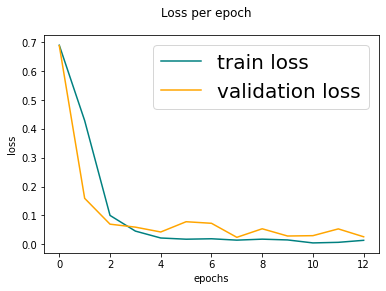

In [ ]:
fig=plt.figure()
plt.plot(hist.history['loss'], color="teal", label="train loss")
plt.plot(hist.history['val_loss'], color="orange", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
fig.suptitle("Loss per epoch")
plt.legend(loc="best", fontsize=20)
plt.show()

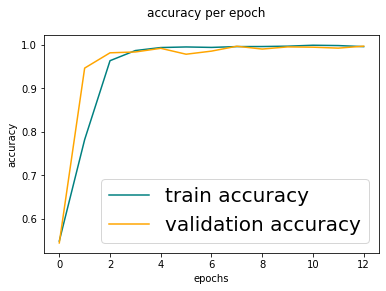

In [ ]:
fig=plt.figure()
plt.plot(hist.history['accuracy'], color="teal", label="train accuracy")
plt.plot(hist.history['val_accuracy'], color="orange", label="validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
fig.suptitle("accuracy per epoch")
plt.legend(loc="best", fontsize=20)
plt.show()

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X,y = batch
  yhat = sequential_model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 1s 605ms/step


In [ ]:
print(f'Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

Precision: 0.9950690269470215, Recall: 0.997035562992096, Accuracy: 0.9965487718582153


# Testing Model

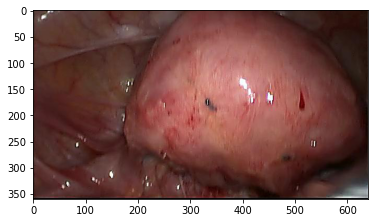

In [ ]:
image1=load_img('/content/drive/MyDrive/GLENDA/data/pathology/c_100_v_(video_3062.mp4)_f_14580_us.jpg')
plt.imshow(image1)
plt.show()

In [ ]:
img_np_array=np.asarray(image1)

In [ ]:
resize=tf.image.resize(img_np_array,(256,256))

In [ ]:
yhat=sequential_model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 224ms/step


array([[0.9999037]], dtype=float32)

In [ ]:
if yhat>0.5:
  print('Pathology detected')
else:
  print('no pathology detected')

Pathology detected


# Visualizing 

In [ ]:
def plot_saliency_cam(model, image, label):
  """
  Plots Saliency map and GradCAM

  Parameters:
  ----------
  arg1: model
      The NN that the images are trained on
  arg2: image (240x240x1)
      The image for which Saliency map GradCAM are to be plotted
  arg3: label
      One-hot encoded true prediction label. Used in score function
  """
  # Creating a model modifier
  replace2linear = ReplaceToLinear()

  # Getting the score to be used in Saliency map and GradCAM
  score = CategoricalScore(np.argmax(label))

  # Getting the Saliency map
  saliency = Saliency(model, model_modifier = replace2linear, clone = True)
  saliency_map = saliency(score, image)

  # Getting the GradCAM
  gradcam = Gradcam(model, model_modifier = replace2linear, clone = True)
  cam = gradcam(score, image)

  # Plotting the Saliency map and GradCAM along with the input image
  fig, axs = plt.subplots(1, 3, figsize=(15,5))
  if label==0:
    fig.suptitle('No-Pathology')
  else:
    fig.suptitle('Pathology')
  
  axs[0].imshow(np.squeeze(image), cmap='gray')
  axs[0].set_title("Input image")
  axs[0].axis('off')

  axs[1].imshow(np.squeeze(saliency_map))
  axs[1].set_title("Saliency map")
  axs[1].axis('off')

  axs[2].imshow(np.squeeze(cam))
  axs[2].set_title("GradCAM")
  axs[2].axis('off')

  plt.show()
  return

In [ ]:
test1= test.as_numpy_iterator()

In [ ]:
batch=test1.next()

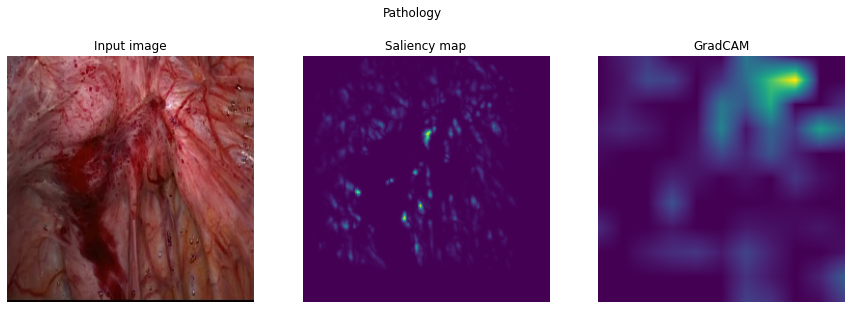

****************************************************************************************************************


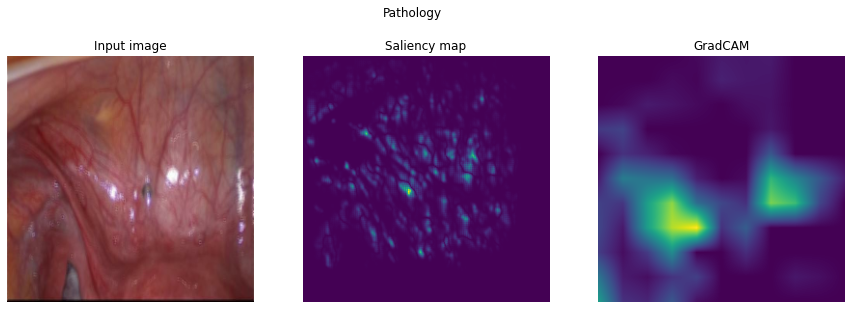

****************************************************************************************************************


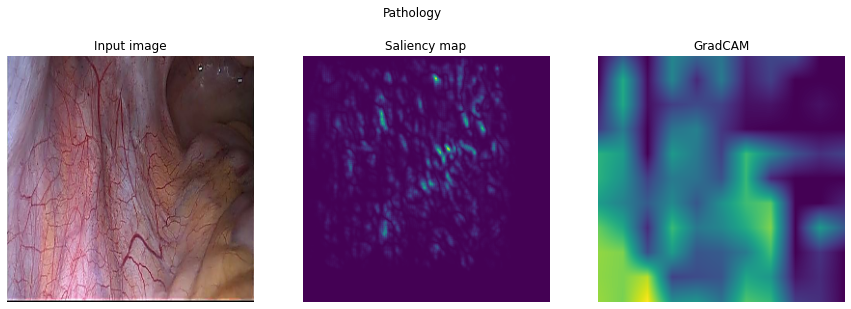

****************************************************************************************************************


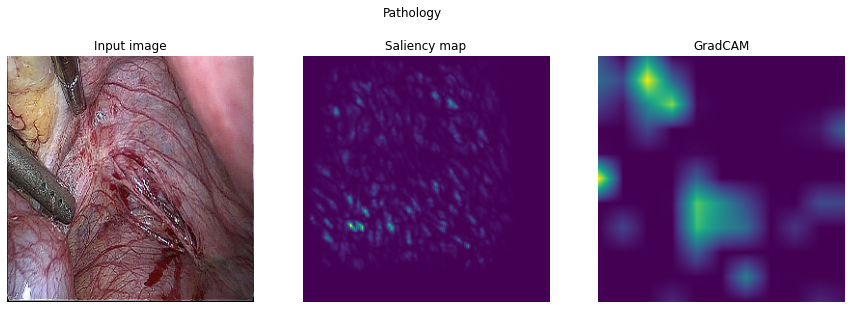

****************************************************************************************************************


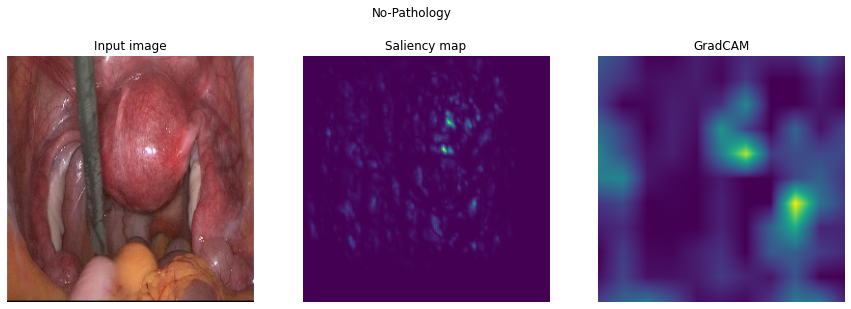

****************************************************************************************************************


In [ ]:
for i in range(5):
  plot_saliency_cam(sequential_model, batch[0][i], batch[1][i])
  print('****************************************************************************************************************')